### Dependences

In [1]:
import sys
sys.path.append("../")

import math
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, Multiply, Add, Dense, Activation, Flatten, Reshape

from PIL import Image
from tqdm import tqdm
import soundfile as sf
import json
import os

import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.model_selection import KFold

import lib.utils as utils

import IPython.display as ipd

TESLA_K40c = '/gpu:1'
GTX_1080 = '/gpu:0'

GPU = TESLA_K40c


In [2]:
#set experiment ID
EXP_ID = "Wavenet_MDCT_128_test"
utils.create_experiment_folders(EXP_ID)
utils.load_experiment_data()


### Loading experiment data

In [3]:
class WaveNet():
    def __init__(self, input_shape=(128, 128, 1), filters=32, nb_stacks = 3, dilation_depth=10):
        # mu: audio quantization size
        # n_residue: residue channels
        # n_skip: skip channels
        # dilation_depth & n_repeat: dilation layer setup
        super(WaveNet, self).__init__()
        self.input_shape = input_shape
        self.filters = filters
        self.nb_stacks = nb_stacks
        self.dilation_depth = dilation_depth

    def __ResidualBlock(self, inpt, filters, dilation_rate):
        original_input = inpt
        
        causal_conv = Conv1D(filters, 1, padding="causal", dilation_rate=2 ** dilation_rate)(inpt)
        act_tanh = Activation('tanh')(causal_conv)
        act_sig = Activation('sigmoid')(causal_conv)

        mult = Multiply()([act_tanh, act_sig])

        res_out = Conv1D(filters, 1, padding="same")(mult)
        skip_connect = Conv1D(filters, 1, padding="same")(res_out)
        res_out = Add()([original_input, res_out])

        return res_out, skip_connect

    def create_model(self):
        skip_connections = []
        
        inpt = Input(shape=self.input_shape, name='input_spec')
        rshp = Reshape((16384,1))(inpt)
        x = Conv1D(self.filters, 2, padding="causal", name="causal_conv")(rshp)
        
        for s in range(self.nb_stacks):
            for i in range(0, self.dilation_depth):
                x, skip_x = self.__ResidualBlock(x, self.filters, i)
                skip_connections.append(skip_x)
        
        x = Add()(skip_connections)
        x = Activation('relu')(x)

        x = Conv1D(1, 1, padding="same")(x)
        x = Activation('relu')(x)

        out = Conv1D(1, 1, padding="same",name="output")(x)
#         out = Activation('softmax',name="output")(x)
        return keras.Model(inpt, out)

# model = WaveNet()
# model = model.create_model()

### Model instantiation

In [ ]:
# model.compile(optimizer='adam', loss='kl_divergence')

# print(model.summary())

### Loading Dataset

In [4]:
inputs = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test_MDCT_128.npy", mmap_mode='c') 
targets = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test_WAVE_MDCT_128.npy", mmap_mode='c') 

qtd_traning = inputs.shape[0]
print("Loaded",qtd_traning, "samples")


Loaded 161994 samples


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val =  train_test_split(inputs, targets, test_size=0.2, random_state=42)

In [ ]:
del inputs, targets

In [5]:
value = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/scale_and_shift_MDCT_128.npy", mmap_mode='c') 
print(value)
SHIFT_VALUE_X, SHIFT_VALUE_Y, SCALE_VALUE_X, SCALE_VALUE_Y = value[0], value[1], value[2], value[3]

[187.74464417 188.26785278 376.08061218 376.6038208 ]


### Dataset Normalization and Batches split

In [ ]:
with tf.device(GPU):
    # Define the model architecture
    model = WaveNet()
    model = model.create_model()

    CONST_GAMA = 0.001
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    X_train = ((X_train+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
    X_val = ((X_val+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
    y_train = y_train/32768
    y_val = y_val/32768
    # Fit data to model
    history = model.fit(X_train, y_train, 
                        batch_size=12,
                        validation_data=(X_val,y_val),
                        epochs=100,
                        verbose=1)

    # Generate generalization metrics
    # scores = model.evaluate(inputs[test], targets[test], verbose=0)
    # print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')


### Metrics

In [6]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [7]:
with tf.device(GPU):
    #default tf.keras metrics
    train_loss = tf.keras.metrics.Mean(name='train_loss')

### Set Loss and load model weights

In [8]:
with tf.device(GPU):
    loss_object = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model = WaveNet()
    model = model.create_model()
#get last saved epoch index and best result in validation step
CURRENT_EPOCH, BEST_VALIDATION = utils.get_model_last_data()
if CURRENT_EPOCH > 0:
    print("Loading last model state in epoch", CURRENT_EPOCH)
    model.load_weights(utils.get_exp_folder_last_epoch())
    print("Best validation result was PSNR=", BEST_VALIDATION)

In [9]:
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_spec (InputLayer)         [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 16384, 1)     0           input_spec[0][0]                 
__________________________________________________________________________________________________
causal_conv (Conv1D)            (None, 16384, 32)    96          reshape[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16384, 32)    1056        causal_conv[0][0]                
_______________________________________________________________________________________

### Training

In [ ]:
@tf.function
def train_step(patch_x, patch_y):
    with tf.device(GPU):
        with tf.GradientTape() as tape:
            predictions = model(patch_x)
            loss = loss_object(patch_y, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def valid_step(valid_x, valid_y, num_val_minibatches, mini_batch_size):
    with tf.device(GPU):
        valid_nrmse = tf.keras.metrics.RootMeanSquaredError()
        valid_KL = tf.keras.metrics.KLDivergence()
        valid_mse = tf.keras.metrics.MeanSquaredError(name='val_mse')
        for i in tqdm(range(1800, 2160)):
            data_x = inputs[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
            data_y = targets[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

            data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
            data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)/32768

            data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA

            predictions = model(data_x)
            valid_mse(data_y, predictions)
            valid_nrmse(data_y, predictions)
            valid_KL(data_y, predictions)
            
        #get metric results
        valid_mse_result = valid_mse.result().numpy()
        valid_nrmse_result = valid_nrmse.result().numpy()
        valid_KL_result = valid_KL.result().numpy()
        
        valid_mse.reset_states()
        valid_nrmse.reset_states()
        valid_KL.reset_states()
        
        return valid_KL_result, valid_nrmse_result, valid_mse_result

        

    #get metric results
    valid_mse.reset_states()
    return valid_mse_result
    
MAX_EPOCHS = 100
EVAL_STEP = 1
CONST_GAMA = 0.001

mini_batch_size = 18
for epoch in range(MAX_EPOCHS):
    
    #TRAINING
    print("TRAINING EPOCH", epoch)
   
    for k in tqdm(range(1800)):
        data_x = inputs[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        data_y = targets[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        
        data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
        data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)/32768
        
        data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        
        train_step(data_x, data_y)
      #VALIDATION
    if epoch%EVAL_STEP == 0:
        clear_output()
        
        print("VALIDATION EPOCH", epoch)
        #saving last epoch model
        model.save_weights(utils.get_exp_folder_last_epoch(), save_format='tf')
       
        #valid with set 1
        print("Validation set")
        psnr_1, nrmse_1, mse_1 = valid_step(inputs[1800 * mini_batch_size : 2160 * mini_batch_size], targets[1800 * mini_batch_size : 2160 * mini_batch_size], mini_batch_size, mini_batch_size)
        
        #valid with set 2
        #print("Validation set 2")
        #psnr_2, nrmse_2, mse_2 = valid_step(valid_x_2, valid_y_2, num_val_minibatches, mini_batch_size)
        psnr_2, nrmse_2, mse_2 = 0, 0, 0
        
        #valid with set 3
        #print("Validation set 3")
        #psnr_3, nrmse_3, mse_3 = valid_step(valid_x_3, valid_y_3, num_val_minibatches, mini_batch_size)
        psnr_3, nrmse_3, mse_3 = 0, 0, 0
        
        utils.update_chart_data(epoch=epoch, train_mse=train_loss.result().numpy(), 
                                valid_mse=[mse_1,mse_2,mse_3], psnr=[psnr_1,psnr_2,psnr_3], nrmse=[nrmse_1,nrmse_2, nrmse_3])
        utils.draw_chart()
        
        #saving best validation model
        if mse_1 < BEST_VALIDATION:
            BEST_VALIDATION = mse_1
            model.save_weights(utils.get_exp_folder_best_valid(), save_format='tf')
        
    train_loss.reset_states()


VALIDATION EPOCH 0


  0%|          | 0/360 [00:00<?, ?it/s]

Validation set


 52%|█████▎    | 189/360 [01:02<00:56,  3.04it/s]

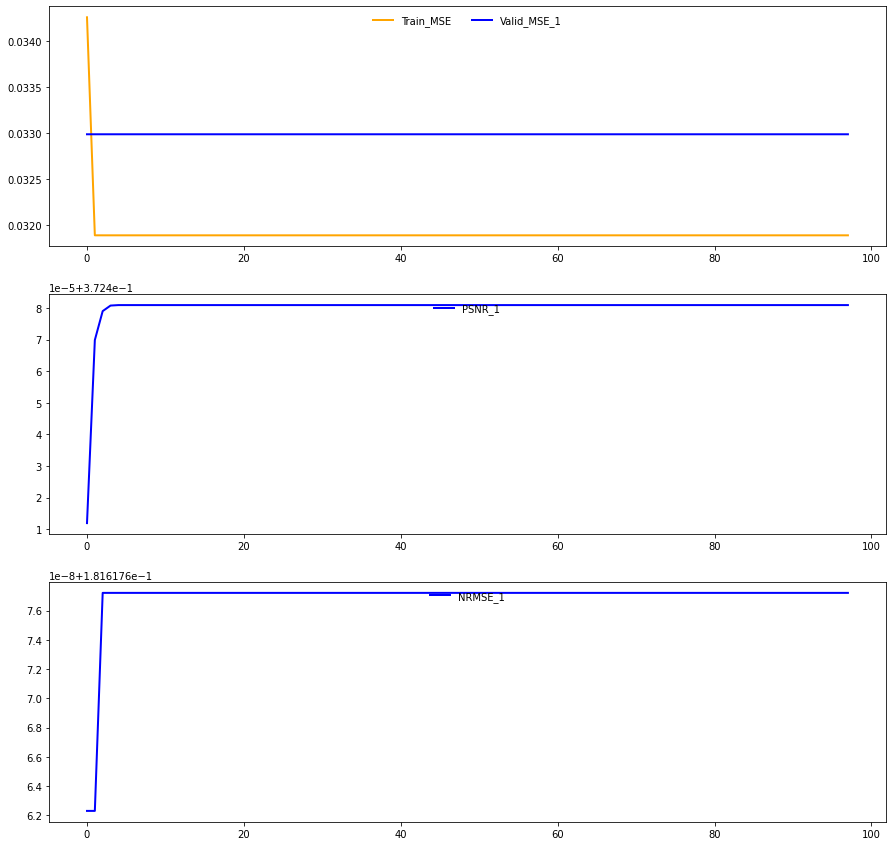

In [16]:
utils.draw_chart()

In [ ]:
#experimentos results
print(utils.get_experiment_results())

In [ ]:
#load best model
model.load_weights(utils.get_exp_folder_best_valid())
CONST_GAMA = 0.001

# valid_x_1 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_val.npy", mmap_mode='c') 
# valid_y_1 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val.npy", mmap_mode='c')

qtd_traning = valid_x_1.shape
print("Loaded",qtd_traning, "samples")

# #normalization
# test_x = utils.shift_and_normalize(test_x, SHIFT_VALUE_X, SCALE_VALUE_X)
# test_y = utils.shift_and_normalize(test_y, SHIFT_VALUE_Y, SCALE_VALUE_Y) 

#batches
num_val_minibatches = math.floor(valid_x_1.shape[0]/mini_batch_size)
# test_batches = utils.random_mini_batches(test_x, test_y, None, None, 8, seed=0)

#metrics
val_mse = tf.keras.metrics.MeanSquaredError(name='val_mse')
val_custom_metrics = utils.CustomMetric()

f = open('/home/arthursrr/Documentos/Audio_Inpainting/Datasets/idx_genders_val.json', "r") 
idx_gen = json.loads(f.read()) 

for k in idx_gen:
    for i in tqdm(idx_gen[k]):
        data_x = valid_x_1[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        data_y = valid_y_1[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

        data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
        data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)

        data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA

        predictions = model(data_x)
        test_mse(data_y, predictions)

        predictions = predictions.numpy()
        data_y = data_y.numpy()

        #feed the metric evaluator
        val_custom_metrics.feed(data_y, predictions)

    #get metric results
    psnr, nrmse = val_custom_metrics.result()
    val_mse_result = test_mse.result().numpy()
    val_custom_metrics.reset_states()
    val_mse.reset_states()
    
    print(k ,"\nPSNR:", psnr,"\nNRMSE:", nrmse)

# Closing file 
f.close() 

## Test

In [ ]:
#load best model
model.load_weights(utils.get_exp_folder_best_valid())
CONST_GAMA = 0.001
test_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/Normalized/X_test.npy", mmap_mode='c') 
test_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/Normalized/y_test.npy", mmap_mode='c')

qtd_traning = test_x.shape
print("Loaded",qtd_traning, "samples")

# #normalization
# test_x = utils.shift_and_normalize(test_x, SHIFT_VALUE_X, SCALE_VALUE_X)
# test_y = utils.shift_and_normalize(test_y, SHIFT_VALUE_Y, SCALE_VALUE_Y) 

#batches
num_test_minibatches = math.floor(test_x.shape[0]/mini_batch_size)
# test_batches = utils.random_mini_batches(test_x, test_y, None, None, 8, seed=0)

#metrics
test_mse = tf.keras.metrics.MeanSquaredError(name='test_mse')
test_custom_metrics = utils.CustomMetric()

f = open('/home/arthursrr/Documentos/Audio_Inpainting/Datasets/idx_genders_test.json', "r") 
idx_gen = json.loads(f.read()) 
flag = True
data_spec = None
data_np = None
for i in tqdm(range(num_test_minibatches)):
    data_x = test_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
    data_y = test_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

    data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
    data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)

    predictions = model(data_x)
    if type(data_spec).__name__ == 'NoneType':
        data_spec = predictions
    else:
        data_spec = tf.concat([data_spec, predictions], axis=0)

    if data_spec.shape[0]%29000 == 0:
        if flag == True:
            data_np = data_spec.numpy()              
            flag = False
        else:
            data_np = np.concatenate((data_np, data_spec.numpy()), axis=0)
        del data_spec
        data_spec = None
if type(data_spec).__name__ != 'NoneType':
    data_np = np.concatenate((data_np, data_spec.numpy()), axis=0)
del data_spec

# Closing file 
f.close() 

In [ ]:
np.save("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/Normalized/X_test_predicted.npy", data_np)

In [ ]:
#load best model
model.load_weights(utils.get_exp_folder_best_valid())
CONST_GAMA = 0.001
test_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_test.npy", mmap_mode='c') 
test_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test.npy", mmap_mode='c')

qtd_traning = test_x.shape
print("Loaded",qtd_traning, "samples")

# #normalization
# test_x = utils.shift_and_normalize(test_x, SHIFT_VALUE_X, SCALE_VALUE_X)
# test_y = utils.shift_and_normalize(test_y, SHIFT_VALUE_Y, SCALE_VALUE_Y) 

#batches
num_test_minibatches = math.floor(test_x.shape[0]/mini_batch_size)
# test_batches = utils.random_mini_batches(test_x, test_y, None, None, 8, seed=0)

#metrics
test_mse = tf.keras.metrics.MeanSquaredError(name='test_mse')
test_custom_metrics = utils.CustomMetric()

f = open('/home/arthursrr/Documentos/Audio_Inpainting/Datasets/idx_genders_test.json', "r") 
idx_gen = json.loads(f.read()) 

for k in idx_gen:
    if k == "Experimental" or k == "Hip-Hop" or k == "Jazz":
        for i in tqdm(idx_gen[k]):
            data_x = test_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
            data_y = test_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

            data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
            data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)

            data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
            data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA

            data_x = data_x.numpy()
            data_y = data_y.numpy()

            #feed the metric evaluator
            test_custom_metrics.feed(data_y, data_x)

        #get metric results
        psnr, nrmse = test_custom_metrics.result()
        test_mse_result = test_mse.result().numpy()
        test_custom_metrics.reset_states()
        test_mse.reset_states()
    
        print(k ,"\nPSNR:", psnr,"\nNRMSE:", nrmse)

# Closing file 
f.close() 

In [ ]:
def griffin_lim(S, frame_length=256, fft_length=255, stride=64):
    '''
    TensorFlow implementation of Griffin-Lim
    Based on https://github.com/Kyubyong/tensorflow-exercises/blob/master/Audio_Processing.ipynb
    '''
    S = tf.expand_dims(S, 0)
    S_complex = tf.identity(tf.cast(S, dtype=tf.complex64))
    y = tf.signal.inverse_stft(S_complex, frame_length, stride, fft_length=fft_length)
    for i in range(100):
        est = tf.signal.stft(y, frame_length, stride, fft_length=fft_length)
        angles = est / tf.cast(tf.maximum(1e-16, tf.abs(est)), tf.complex64)
        y = tf.signal.inverse_stft(S_complex * angles, frame_length, stride, fft_length=fft_length)
    return tf.squeeze(y, 0)

In [ ]:
model.load_weights(utils.get_exp_folder_best_valid())

test_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/Normalized/X_test.npy", mmap_mode='c') 
test_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/Normalized/y_test.npy", mmap_mode='c')

qtd_traning = test_x.shape
print("Loaded",qtd_traning, "samples")

#batches
num_test_minibatches = math.floor(test_x.shape[0]/mini_batch_size)

#metrics
test_mse = tf.keras.metrics.MeanSquaredError(name='test_mse')
test_custom_metrics = utils.CustomMetric()

CONST_GAMA = 0.001

f = open('/home/arthursrr/Documentos/Audio_Inpainting/Datasets/idx_genders_test.json', "r") 
idx_gen = json.loads(f.read()) 

wave_original = None
wave_corte = None
wave_pred = None

for k in idx_gen:
    path_gen = "/mnt/backup/arthur/Free_Music_Archive/Teste/"+k
    if not os.path.exists(path_gen):
            os.makedirs(path_gen)
            os.makedirs(path_gen+"/original")
            os.makedirs(path_gen+"/cortado")
            os.makedirs(path_gen+"/predito")
    for i in tqdm(idx_gen[k]):
        data_x = test_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        data_y = test_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

        data_norm = ((tf.convert_to_tensor(data_x, dtype=tf.float32)+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA

        predictions = model(data_norm)
        
        predictions = (((predictions-CONST_GAMA)*SCALE_VALUE_X)-SHIFT_VALUE_X).numpy()
        
        #predictions = utils.inv_shift_and_normalize(predictions, SHIFT_VALUE_Y, SCALE_VALUE_Y)   
        
        audio_original = None
        audio_corte = None
        audio_pred = None
        
        for j in range(mini_batch_size):
            if j==0:
                audio_original = data_y[j,:,:,0]
                audio_corte = data_x[j,:,:,0]
                audio_pred = predictions[j,:,:,0]
            else:
                audio_original = np.concatenate((audio_original, data_y[j,:,:,0]), axis=0)
                audio_corte = np.concatenate((audio_corte, data_x[j,:,:,0]), axis=0)
                audio_pred = np.concatenate((audio_pred, predictions[j,:,:,0]), axis=0)
        
        wave_original = griffin_lim(audio_original, frame_length=256, fft_length=255, stride=64)
        wave_corte = griffin_lim(audio_corte, frame_length=256, fft_length=255, stride=64)
        wave_pred = griffin_lim(audio_pred, frame_length=256, fft_length=255, stride=64)
        
        sf.write(path_gen+"/original/"+str(i)+".wav", wave_original, 16000, subtype='PCM_16')
        sf.write(path_gen+"/cortado/"+str(i)+".wav", wave_corte, 16000, subtype='PCM_16')
        sf.write(path_gen+"/predito/"+str(i)+".wav", wave_pred, 16000, subtype='PCM_16')

In [ ]:
audio_pred = None
for i in range(0, 58):
    if i==0:
        audio_pred = predictions[i,:,:,0]
    else:
        audio_pred = np.concatenate((audio_pred, predictions[i,:,:,0]), axis=0)
audio_pred.shape

In [ ]:
audio_corte = None
for i in range(0, 58):
    if i==0:
        audio_corte = data_x[i,:,:,0]
    else:
        audio_corte = np.concatenate((audio_corte, data_x[i,:,:,0]), axis=0)
audio_corte.shape

In [ ]:
audio_original = None
for i in range(0, 58):
    if i==0:
        audio_original = data_y[i,:,:,0]
    else:
        audio_original = np.concatenate((audio_original, data_y[i,:,:,0]), axis=0)
audio_original.shape

In [ ]:
wave_original = griffin_lim(audio_original, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave_original, rate=16000)

In [ ]:
wave_corte = griffin_lim(audio_corte, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave_corte, rate=16000)

In [ ]:
wave_pred = griffin_lim(audio_pred, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave_pred, rate=16000)

In [ ]:
# import soundfile as sf
# sf.write('x.wav', wave_corte, 16000, subtype='PCM_16')
# sf.write('pred.wav', wave_pred, 16000, subtype='PCM_16')